In [23]:
import pickle
import sklearn.metrics
import numpy as np
import pandas as pd

with open('pred_gt.pickle', mode='rb') as f:
    pr0,pr1,pr2, gt0,gt1,gt2 = pickle.load(f)

if False:
    def softmax(x):
        u = np.sum(np.exp(x))
        return np.exp(x)/u

    pr0 = np.array( [softmax(e) for e in pr0] )
    pr1 = np.array( [softmax(e) for e in pr1] )
    pr2 = np.array( [softmax(e) for e in pr2] )
                 

In [2]:
COUNT_GRAPHEME = [147, 145, 337, 318, 331, 175, 308, 153, 157, 444, 152, 151, 146, 5420, 796, 1083, 940, 761, 1633, 278, 336, 942, 2961, 5149, 336, 1127, 171, 305, 759, 2780, 437, 768, 1127, 136, 276, 476, 1024, 285, 3354, 617, 757, 305, 1957, 3630, 1057, 144, 580, 452, 1376, 321, 738, 326, 935, 3690, 592, 1680, 2688, 633, 1285, 2339, 426, 575, 868, 149, 5596, 1365, 786, 475, 631, 757, 957, 2936, 5736, 130, 1518, 1127, 1936, 957, 293, 3458, 456, 3438, 292, 1418, 460, 1363, 2094, 168, 760, 2313, 627, 1539, 1116, 622, 973, 727, 4926, 481, 627, 458, 448, 1083, 141, 3461, 160, 151, 751, 5321, 158, 908, 342, 787, 886, 4395, 150, 4015, 436, 1531, 1139, 1537, 1207, 462, 2313, 2073, 2188, 813, 159, 927, 952, 978, 144, 443, 1039, 4374, 623, 637, 1051, 562, 934, 2312, 883, 1746, 1067, 609, 612, 317, 302, 4392, 1723, 2402, 2311, 1248, 607, 1553, 732, 928, 790, 324, 143, 3281, 480, 311, 465, 165, 164, 1142, 307, 1585]
COUNT_VOWEL = [41508, 36886, 25967, 16152, 18848, 5297, 4336, 28723, 3528, 16032, 3563]
COUNT_CONSONANT = [125278, 7424, 23465, 619, 21270, 21397, 1387]

In [3]:
def metric(gt, pred):
    return sklearn.metrics.recall_score(gt, pred, average='macro')

In [4]:
print( metric(gt0, pr0.argmax(axis=-1)) )
print( metric(gt1, pr1.argmax(axis=-1)) )
print( metric(gt2, pr2.argmax(axis=-1)) )

0.969952326398697
0.9885415812178766
0.9843449895580493


In [5]:
0.5 * metric(gt0, (pr0).argmax(axis=-1)) + 0.25* metric(gt1, (pr1).argmax(axis=-1)) + 0.25 * metric(gt2, (pr2).argmax(axis=-1)) 

0.9781978058933299

In [16]:
print( metric(gt0, (pr0 / COUNT_GRAPHEME ).argmax(axis=-1)) )
print( metric(gt1, (pr1 / COUNT_VOWEL    ).argmax(axis=-1)) )
print( metric(gt2, (pr2 / COUNT_CONSONANT).argmax(axis=-1)) )

0.9721084099025697
0.9897781052047331
0.9875167802295116


In [97]:
df = pd.read_csv( "../input/bengaliai-cv19/train.csv" )
df_fold  = pd.read_csv( "../input/train_with_fold.csv" )
df_char = pd.read_csv( "../input/bengaliai-cv19/class_map.csv" )
def get_c0(idx):
    return df_char[(df_char.component_type == 'grapheme_root') & (df_char.label==idx)].component.values[0]

df_char

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই
...,...,...,...
181,consonant_diacritic,2,র্
182,consonant_diacritic,3,র্য
183,consonant_diacritic,4,্য
184,consonant_diacritic,5,্র


In [32]:
fold0 = df_fold[df_fold.fold==0].index
fold0

Int64Index([     9,     12,     20,     44,     48,     70,     90,     91,
                99,    116,
            ...
            200786, 200792, 200798, 200807, 200814, 200820, 200825, 200830,
            200834, 200835],
           dtype='int64', length=40168)

In [127]:
def inspect_macro_recall(gt, pred):
    ret = []
    for class_id in range(168):
        total  = np.sum(gt == class_id )
        ok = np.sum(np.logical_and( gt == class_id, pred == class_id ))
        recall = float(ok) / total
        ng_index = np.where( np.logical_and( gt == class_id, pred != class_id ) )
        confused_with = pred[ng_index]
        confused_with = [(e,get_c0(e)) for e in confused_with]
        ret.append({'id': class_id,'recall': recall, 'total': total, 'ng': total-ok, 'ng_index': ng_index, 'confused_with': confused_with})
    return ret

In [128]:
get_c0(1)

'ঃ'

In [131]:
ret = inspect_macro_recall(gt0, (pr0 / COUNT_GRAPHEME ).argmax(axis=-1))
for e in sorted(ret, key=lambda e:e['recall']):
    image_id = [fold0[ e ] for e in e['ng_index'][0]]
    ngs = list(zip(e['confused_with'] , image_id))
    print(f"<<<{e['id']:3d} {get_c0(e['id'])}>>> {e['recall']*100:.2f}% {e['total']:5d}   NG{e['ng']} {ngs}")
    #print(f"[{e['id']:3d} {get_c0(e['id'])}] {e['recall']*100:.2f}% {e['total']:5d}   NG{e['ng']} {e['confused_with']} {e['ng_index']}")
    #print( elm)

<<< 84 ন্ঠ>>> 69.62%    79   NG24 [((61, 'ণ্ঠ'), 311), ((61, 'ণ্ঠ'), 8804), ((61, 'ণ্ঠ'), 38032), ((61, 'ণ্ঠ'), 45393), ((61, 'ণ্ঠ'), 54721), ((142, 'ষ্ঠ'), 54889), ((61, 'ণ্ঠ'), 57893), ((61, 'ণ্ঠ'), 76151), ((61, 'ণ্ঠ'), 83119), ((61, 'ণ্ঠ'), 106835), ((61, 'ণ্ঠ'), 109488), ((61, 'ণ্ঠ'), 111914), ((61, 'ণ্ঠ'), 130996), ((61, 'ণ্ঠ'), 139737), ((61, 'ণ্ঠ'), 153532), ((61, 'ণ্ঠ'), 160563), ((61, 'ণ্ঠ'), 173255), ((61, 'ণ্ঠ'), 183532), ((61, 'ণ্ঠ'), 184717), ((61, 'ণ্ঠ'), 186614), ((61, 'ণ্ঠ'), 190326), ((61, 'ণ্ঠ'), 190945), ((61, 'ণ্ঠ'), 192804), ((61, 'ণ্ঠ'), 196326)]
<<< 62 ণ্ড>>> 84.44%   180   NG28 [((86, 'ন্ত'), 3724), ((86, 'ন্ত'), 5269), ((65, 'ত্ত'), 7558), ((85, 'ন্ড'), 8040), ((128, 'ল্ড'), 19322), ((85, 'ন্ড'), 21485), ((86, 'ন্ত'), 29378), ((85, 'ন্ড'), 36165), ((65, 'ত্ত'), 40302), ((86, 'ন্ত'), 49415), ((85, 'ন্ড'), 55057), ((86, 'ন্ত'), 60423), ((65, 'ত্ত'), 80621), ((86, 'ন্ত'), 83942), ((86, 'ন্ত'), 93673), ((86, 'ন্ত'), 97749), ((86, 'ন্ত'), 102364), ((86, 'ন্ত'), 109

<<<164 ৎ>>> 100.00%    26   NG0 []


In [37]:
df.iloc[fold0]

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
9,Train_9,64,7,1,তেঁ
12,Train_12,74,1,2,র্দ্দা
20,Train_20,42,0,2,র্ছ
44,Train_44,38,5,4,চ্যূ
48,Train_48,124,1,2,র্লা
...,...,...,...,...,...
200820,Train_200820,59,1,4,ণ্যা
200825,Train_200825,138,4,0,শ্লু
200830,Train_200830,39,2,0,চ্চি
200834,Train_200834,144,1,5,ষ্প্রা


In [149]:
graphemes = pd.read_csv( "../input/bengaliai-cv19/class_map.csv" ).component.values
split = [list(e) for e in graphemes]
char_parts = np.concatenate(split)

print("parts before uniq()", len(char_parts))
print("parts after uniq()", len(np.unique(char_parts)))

print(char_parts)
char_parts = np.sort( np.unique(char_parts) )
print(char_parts)

print(char_parts[char_parts != '0'])


parts before uniq() 450
parts after uniq() 62
['ং' 'ঃ' 'অ' 'আ' 'ই' 'ঈ' 'উ' 'ঊ' 'ঋ' 'এ' 'ঐ' 'ও' 'ঔ' 'ক' 'ক' '্' 'ক' 'ক'
 '্' 'ট' 'ক' '্' 'ত' 'ক' '্' 'ল' 'ক' '্' 'ষ' 'ক' '্' 'ষ' '্' 'ণ' 'ক' '্'
 'ষ' '্' 'ম' 'ক' '্' 'স' 'খ' 'গ' 'গ' '্' 'ধ' 'গ' '্' 'ন' 'গ' '্' 'ব' 'গ'
 '্' 'ম' 'গ' '্' 'ল' 'ঘ' 'ঘ' '্' 'ন' 'ঙ' 'ঙ' '্' 'ক' 'ঙ' '্' 'ক' '্' 'ত'
 'ঙ' '্' 'ক' '্' 'ষ' 'ঙ' '্' 'খ' 'ঙ' '্' 'গ' 'ঙ' '্' 'ঘ' 'চ' 'চ' '্' 'চ'
 'চ' '্' 'ছ' 'চ' '্' 'ছ' '্' 'ব' 'ছ' 'জ' 'জ' '্' 'জ' 'জ' '্' 'জ' '্' 'ব'
 'জ' '্' 'ঞ' 'জ' '্' 'ব' 'ঝ' 'ঞ' 'ঞ' '্' 'চ' 'ঞ' '্' 'ছ' 'ঞ' '্' 'জ' 'ট'
 'ট' '্' 'ট' 'ঠ' 'ড' 'ড' '্' 'ড' 'ঢ' 'ণ' 'ণ' '্' 'ট' 'ণ' '্' 'ঠ' 'ণ' '্'
 'ড' 'ণ' '্' 'ণ' 'ত' 'ত' '্' 'ত' 'ত' '্' 'ত' '্' 'ব' 'ত' '্' 'থ' 'ত' '্'
 'ন' 'ত' '্' 'ব' 'ত' '্' 'ম' 'থ' 'দ' 'দ' '্' 'ঘ' 'দ' '্' 'দ' 'দ' '্' 'ধ'
 'দ' '্' 'ব' 'দ' '্' 'ভ' 'দ' '্' 'ম' 'ধ' 'ধ' '্' 'ব' 'ন' 'ন' '্' 'জ' 'ন'
 '্' 'ট' 'ন' '্' 'ঠ' 'ন' '্' 'ড' 'ন' '্' 'ত' 'ন' '্' 'ত' '্' 'ব' 'ন' '্'
 'থ' 'ন' '্' 'দ' 'ন' '্' 'দ' '্' 'ব' 'ন' '্' 'ধ' 'ন' '্' 'ন' 'ন' '্' 'ব'
 'ন' 

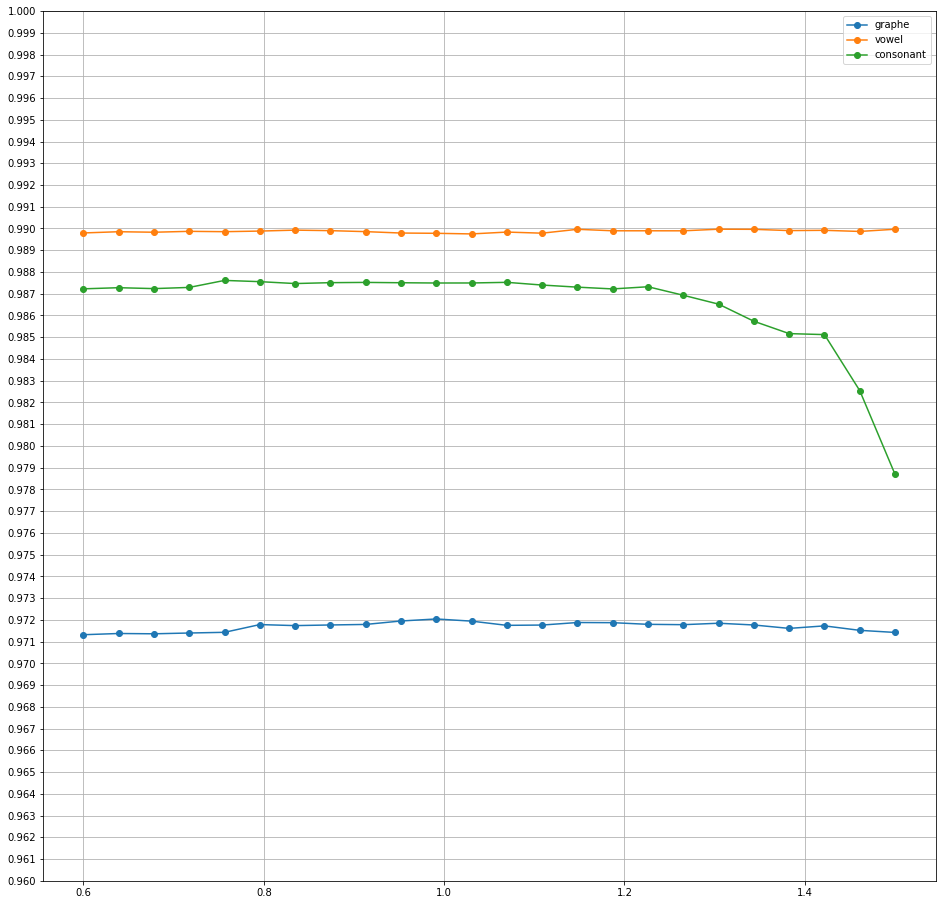

In [18]:
import matplotlib.pyplot as plt

arr = []
# parr = np.linspace(0, 1.6, 60)
# parr = np.linspace(-0.2, 0.4, 24)
parr = np.linspace(0.6, 1.5, 24)
for p in parr:
    s0 = metric(gt0, (pr0 / np.power(COUNT_GRAPHEME, p) ).argmax(axis=-1))
    s1 = metric(gt1, (pr1 / np.power(COUNT_VOWEL,    p) ).argmax(axis=-1))
    s2 = metric(gt2, (pr2 / np.power(COUNT_CONSONANT,p) ).argmax(axis=-1)) 
    arr.append([s0,s1,s2])
arr = np.array(arr)

plt.figure(figsize=(16,16))

plt.plot(parr, arr[:,0], "o-", label="graphe")
plt.plot(parr, arr[:,1], "o-", label="vowel")
plt.plot(parr, arr[:,2], "o-", label="consonant")

plt.grid()
plt.yticks(np.linspace(0.96,1, 41))
plt.ylim(0.96, 1)
plt.legend()
plt.show()

In [8]:
0.5 * metric(gt0, (pr0 / COUNT_GRAPHEME ).argmax(axis=-1)) + 0.25* metric(gt1, (pr1 / COUNT_VOWEL    ).argmax(axis=-1)) + 0.25 * metric(gt2, (pr2 / COUNT_CONSONANT).argmax(axis=-1)) 

0.980377926309846

(array([  6.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   1., 270.]),
 array([7.9115918e-05, 1.0003646e-01, 1.9999380e-01, 2.9995114e-01,
        3.9990848e-01, 4.9986583e-01, 5.9982318e-01, 6.9978052e-01,
        7.9973787e-01, 8.9969522e-01, 9.9965256e-01], dtype=float32),
 <a list of 10 Patch objects>)

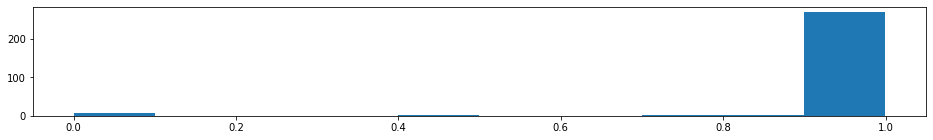

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,2))
#pr2[gt2==6][:, 6 ].size  # gt is 6, check prob of 6
#sns.distplot( pr2[gt2==6][:, 6 ] )  # gt is 6, check prob of 6
plt.hist( pr2[gt2==6][:, 6 ] )  # gt is 6, check prob of 6

In [10]:
arr = np.where( np.bitwise_and( gt2==6 , pr2[:,6] < 0.5) )
arr

(array([ 2749, 10571, 24893, 25160, 26098, 26981, 29277]),)

In [11]:
for e in arr:
    print( ( pr2[e] * 100 ).astype(int) )

[[ 0  0  0  0 99  0  0]
 [ 0  0  0  0 99  0  0]
 [ 0  0  0  0 97  0  2]
 [ 0  0  0  0  0 95  3]
 [ 0  0  0  0  0 99  0]
 [ 0  0  0  0  0 99  0]
 [ 4  0  1  0 51  0 41]]


In [12]:
def print_mayoi(true_class_dx):
    arr = np.where( np.bitwise_and( gt2==true_class_dx , pr2[:,true_class_dx] < 0.5) )
    for dx in arr:
        print( ( pr2[dx] * 100 ).astype(int) )

In [13]:
print_mayoi(6) # それなりにまよっていることがわかる
#print_mayoi(5)

[[ 0  0  0  0 99  0  0]
 [ 0  0  0  0 99  0  0]
 [ 0  0  0  0 97  0  2]
 [ 0  0  0  0  0 95  3]
 [ 0  0  0  0  0 99  0]
 [ 0  0  0  0  0 99  0]
 [ 4  0  1  0 51  0 41]]


In [14]:
pred2 = []
for e in pr2:
    pred2.append( ( e / COUNT_CONSONANT).argmax() )

In [15]:
metric(gt2, pred2)

0.9875167802295116